In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from lightgbm import LGBMClassifier


In [2]:
# Load the Titanic dataset from Seaborn
data = sns.load_dataset('titanic')

# Drop rows with missing values in the target column ('survived') for simplicity
data = data.dropna(subset=['survived'])

# Define target and features
X = data.drop('survived', axis=1)
y = data['survived']

X.shape, y.shape

((891, 14), (891,))

In [3]:
# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 14), (179, 14), (712,), (179,))

In [4]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
331,1,male,45.5,0,0,28.5000,S,First,man,True,C,Southampton,no,True
733,2,male,23.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
382,3,male,32.0,0,0,7.9250,S,Third,man,True,NaN,Southampton,no,True
704,3,male,26.0,1,0,7.8542,S,Third,man,True,NaN,Southampton,no,False
813,3,female,6.0,4,2,31.2750,S,Third,child,False,NaN,Southampton,no,False


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pclass       712 non-null    int64   
 1   sex          712 non-null    object  
 2   age          572 non-null    float64 
 3   sibsp        712 non-null    int64   
 4   parch        712 non-null    int64   
 5   fare         712 non-null    float64 
 6   embarked     710 non-null    object  
 7   class        712 non-null    category
 8   who          712 non-null    object  
 9   adult_male   712 non-null    bool    
 10  deck         158 non-null    category
 11  embark_town  710 non-null    object  
 12  alive        712 non-null    object  
 13  alone        712 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(3), object(5)
memory usage: 64.4+ KB


In [6]:
X_train.describe()

,pclass,age,sibsp,parch,fare
count,712.000000,572.000000,712.000000,712.000000,712.000000
mean,2.330056,29.498846,0.553371,0.379213,32.586276
std,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.925000
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,30.500000
max,3.000000,80.000000,8.000000,6.000000,512.329200


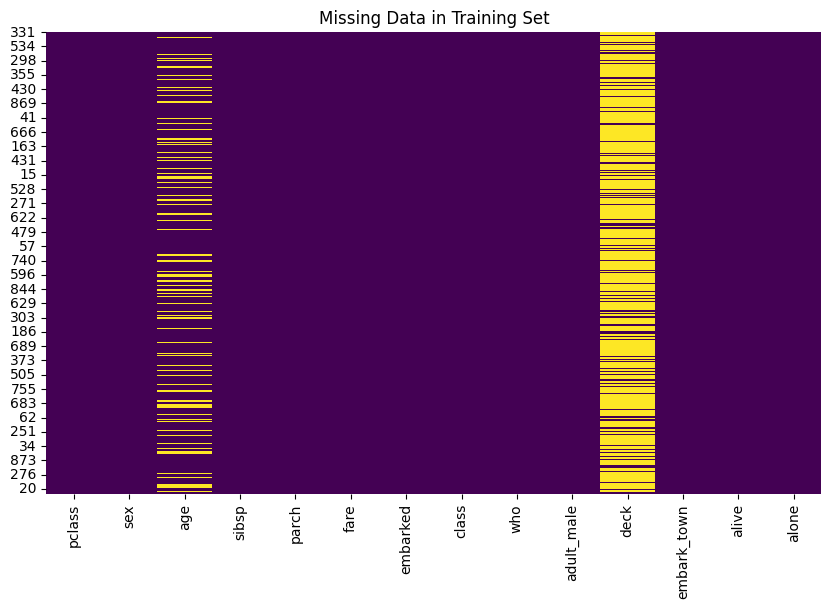

In [7]:
# Visualize missing data in the training set
plt.figure(figsize=(10, 6))
sns.heatmap(X_train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data in Training Set')
plt.show()

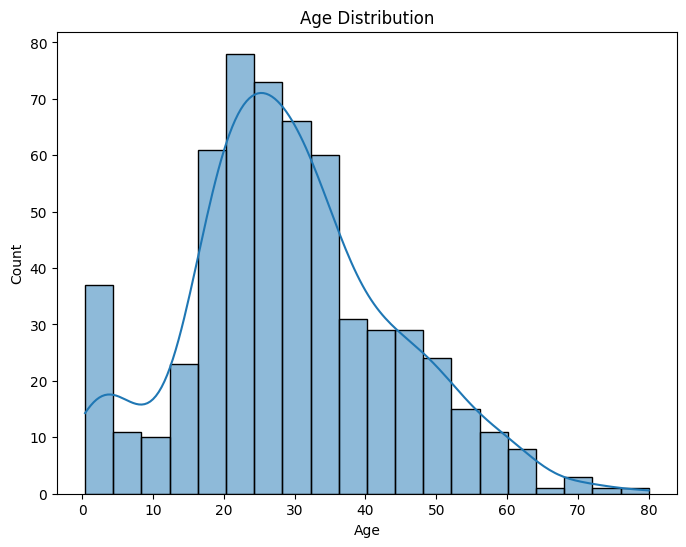

In [8]:
# Age distribution
plt.figure(figsize=(8, 6))
sns.histplot(X_train['age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

In [9]:
def plot_countplot(data, column, title, hue=None):
    plt.figure(figsize=(5, 3))
    sns.countplot(x=column, data=data, hue=hue)
    plt.title(title)
    plt.xlabel(column)
    plt.show()

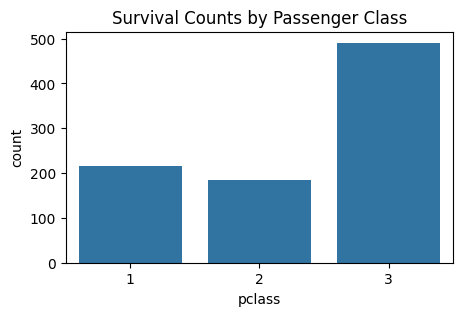

In [10]:
plot_countplot(data, 'pclass', 'Survival Counts by Passenger Class')

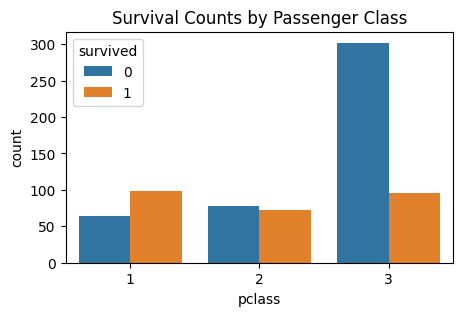

In [11]:
plot_countplot(X_train, 'pclass', 'Survival Counts by Passenger Class', y_train)

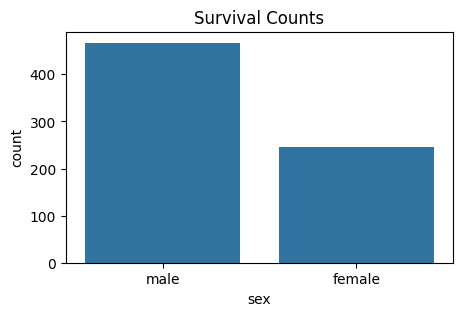

In [12]:
plot_countplot(X_train, 'sex', 'Survival Counts')

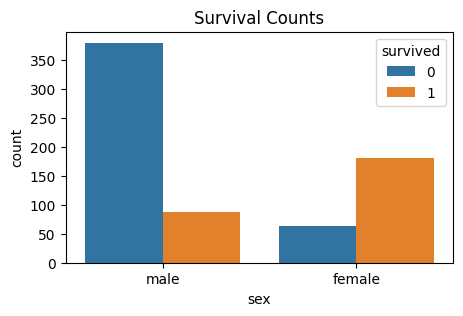

In [13]:
plot_countplot(X_train, 'sex', 'Survival Counts', y_train)

<Axes: xlabel='pclass', ylabel='age'>

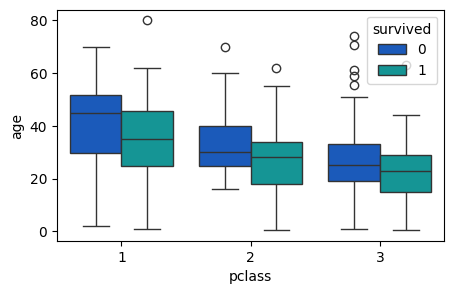

In [14]:
plt.figure(figsize=(5, 3))
sns.boxplot(x="pclass", y="age", data=X_train, palette='winter', hue=y_train)

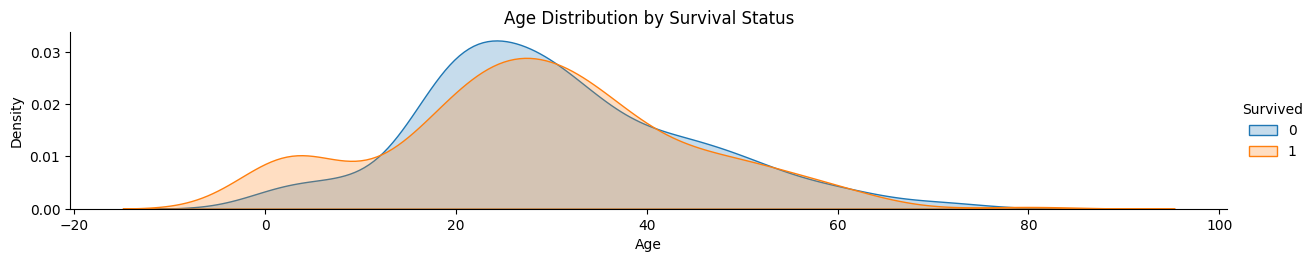

In [15]:
# Combine X_train and y_train for plotting
X_train_plot = X_train.copy()
X_train_plot['survived'] = y_train  # Adding the target variable as a column in X_train

# Create a FacetGrid to plot the age distribution by survival status
g = sns.FacetGrid(X_train_plot, hue='survived', height=2.5, aspect=5)
g.map(sns.kdeplot, 'age', fill=True)
g.add_legend(title='Survived')
plt.title('Age Distribution by Survival Status')
plt.xlabel('Age')
plt.show()

In [16]:
X_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class',
       'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'],
      dtype='object')

In [17]:
# Define numerical and categorical feature groups
numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked', 'who', 'adult_male', 'alone']
drop_features = ['deck', 'embark_town', 'class', 'alive']

In [18]:
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
# Numerical pipeline: impute missing values with median
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# Categorical pipeline: impute with mode and one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore')),
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features),
    ('drop_cols', 'drop', drop_features)  # Drop unwanted columns
])

In [20]:
# # Full pipeline with preprocessor and model
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=42))  # Substitute with any other classifier as needed
# ])

In [21]:
# # Define the parameter grid for grid search
# param_grid = {
#     'preprocessor__num__imputer__strategy': ['mean', 'median'],  # Options for numerical imputation
#     'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],  # Options for categorical imputation
#     'classifier__n_estimators': [20, 30, 40, 50, 60],  # Number of trees in the forest
#     'classifier__max_depth': [3, 4, 5, 6],  # Maximum depth of the tree
# }

In [22]:
# # Setup GridSearchCV with the pipeline and parameter grid
# grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [23]:
# # Fit the model on the training data
# grid_search.fit(X_train_imp, y_train_imp)

# # Output the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

In [24]:
# # Access the best pipeline with optimized parameters
# best_pipeline = grid_search.best_estimator_

# # Evaluate the optimized pipeline on the test data
# test_score = best_pipeline.score(X_test_imp, y_test_imp)
# print("Test Score with Best Pipeline:", test_score)

In [25]:
def plot_heatmap(grid_search, params, axes):
    # Convert grid search results to a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    # Extract columns relevant to the parameter grid and mean test score
    columns = [f'param_{name}' for name in params + axes] + ['mean_test_score']
    results = results[columns]

    # Loop through each combination of imputer strategies and plot heatmaps
    for num_strategy in results[columns[0]].unique():
        for cat_strategy in results[columns[1]].unique():
            # Filter data for the current strategy combination
            subset = results[
                (results[columns[0]] == num_strategy) &
                (results[columns[1]] == cat_strategy)
            ]

            # Aggregate duplicate entries by taking the mean of `mean_test_score`
            subset = subset.groupby(columns[-3:-1], as_index=False)[columns[-1]].mean()

            # Pivot the data for heatmap plotting
            heatmap_data = subset.pivot(
                index=columns[-3], 
                columns=columns[-2], 
                values=columns[-1],
            )

            # Plot heatmap
            plt.figure(figsize=(5, 5))
            sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean Test Score'})
            plt.title(f"Imputer Strategies: Num={num_strategy}, Cat={cat_strategy}")
            plt.xlabel('Number of Estimators')
            plt.ylabel('Max Depth')
            plt.show()

In [26]:
# def plot_heatmap(grid_search):
#     # Convert grid search results to a DataFrame
#     results = pd.DataFrame(grid_search.cv_results_)

#     # Extract columns relevant to the parameter grid and mean test score
#     results = results[
#         [
#             'param_preprocessor__num__imputer__strategy', 
#             'param_preprocessor__cat__imputer__strategy', 
#             'param_classifier__n_estimators', 
#             'param_classifier__max_depth', 
#             'mean_test_score',
#         ],
#     ]

#     # Loop through each combination of imputer strategies and plot heatmaps
#     for num_strategy in results['param_preprocessor__num__imputer__strategy'].unique():
#         for cat_strategy in results['param_preprocessor__cat__imputer__strategy'].unique():
#             # Filter data for the current strategy combination
#             subset = results[
#                 (results['param_preprocessor__num__imputer__strategy'] == num_strategy) &
#                 (results['param_preprocessor__cat__imputer__strategy'] == cat_strategy)
#             ]

#             # Pivot the data for heatmap plotting
#             heatmap_data = subset.pivot(
#                 index='param_classifier__max_depth', 
#                 columns='param_classifier__n_estimators', 
#                 values='mean_test_score',
#             )

#             # Plot heatmap
#             plt.figure(figsize=(8, 6))
#             sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean Test Score'})
#             plt.title(f"Heatmap for Imputer Strategies: Num={num_strategy}, Cat={cat_strategy}")
#             plt.xlabel('Number of Estimators')
#             plt.ylabel('Max Depth')
#             plt.show()

In [ ]:
def train_grids(algorithm, model_params, grid_params, X_train, X_test, y_train, y_test, heatmap_keys=None):
    # Full pipeline with preprocessor and model
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', algorithm(**model_params))  # Substitute with any other classifier as needed
    ])

    # Define the parameter grid for grid search
    preprocessor_params = {
        'preprocessor__num__imputer__strategy': ['mean', 'median'],  # Options for numerical imputation
        'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],  # Options for categorical imputation
    }
    algorithm_params = {f"classifier__{key}": value for key, value in grid_params.items()}
    search_grid_params = {**preprocessor_params, **algorithm_params}

    # Setup GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(model_pipeline, search_grid_params, cv=5, scoring='accuracy', refit=True, n_jobs=-1)

    # Fit the model on the training data
    grid_search.fit(X_train, y_train)

    # Output the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Access the best pipeline with optimized parameters
    best_pipeline = grid_search.best_estimator_

    # Evaluate the optimized pipeline on the test data
    test_score = best_pipeline.score(X_test, y_test)
    print("Test Score with Best Pipeline:", test_score)

    plot_heatmap(
        grid_search,
        list(preprocessor_params.keys()),
        [f"classifier__{key}" for key in heatmap_keys] if heatmap_keys else list(algorithm_params.keys())[:2],
    )

    return best_pipeline

Best Parameters: {'classifier__max_depth': 5, 'classifier__max_features': 3, 'classifier__n_estimators': 30, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}
Best Score: 0.833162552398696
Test Score with Best Pipeline: 0.8531468531468531


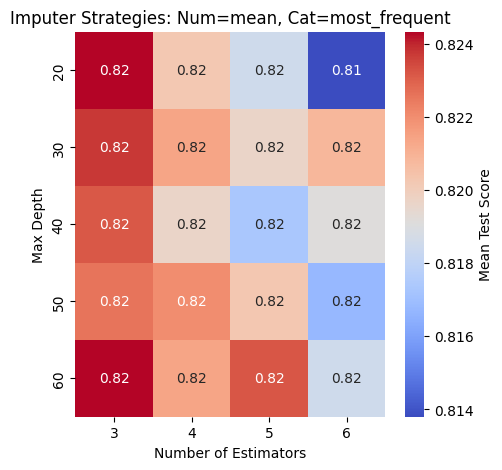

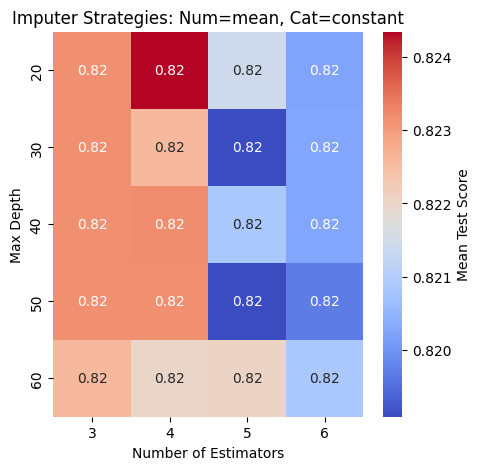

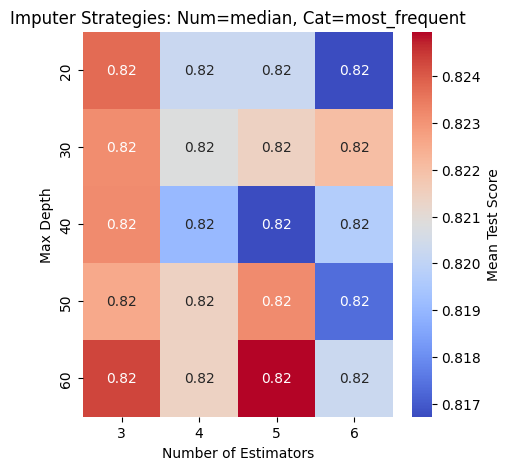

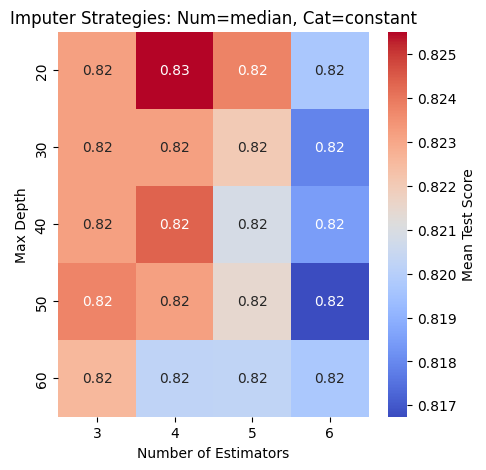

In [28]:
# RandomForestClassifier run
grid_params = {
    'n_estimators': [20, 30, 40, 50, 60],  # Number of trees in the forest
    'max_depth': [3, 4, 5, 6],  # Maximum depth of the tree
    'max_features': [3, 5, 10],
}
model_params = {"random_state": 42}

random_forest_clf = train_grids(
    RandomForestClassifier,
    model_params,
    grid_params,
    X_train_imp,
    X_test_imp,
    y_train_imp,
    y_test_imp,
    heatmap_keys=['n_estimators', 'max_depth'],
)

Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'median'}
Best Score: 0.8278528178854214
Test Score with Best Pipeline: 0.8111888111888111


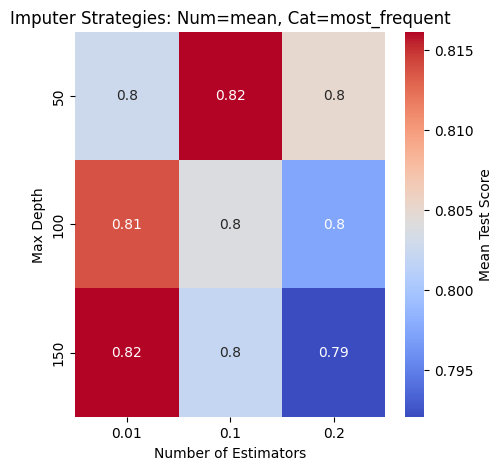

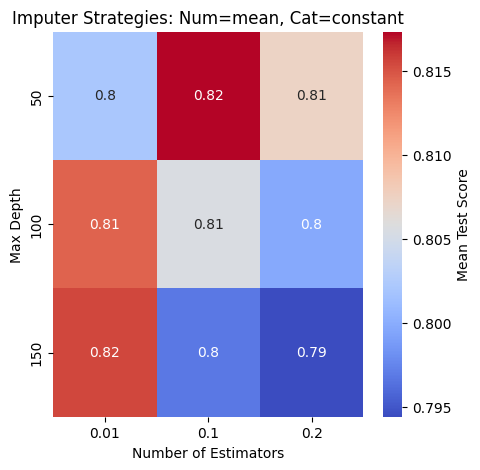

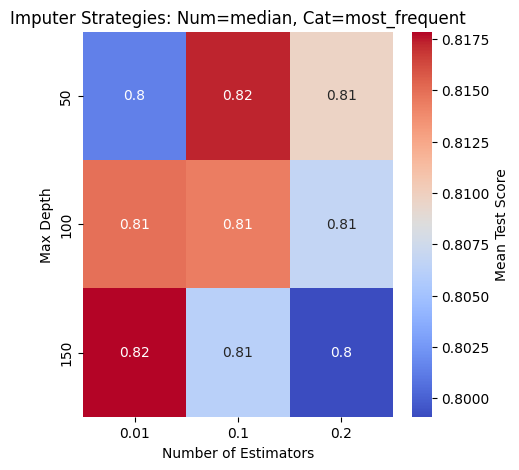

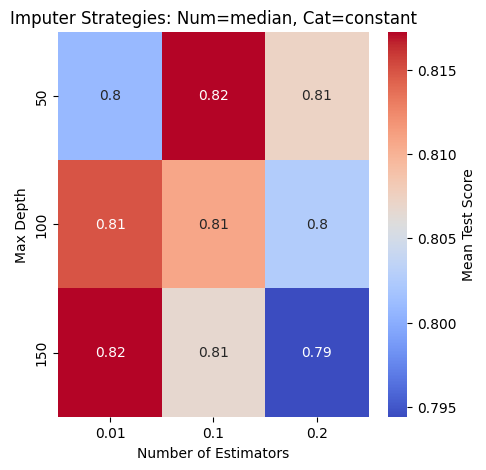

In [29]:
# GradientBoostingClassifier grid parameters
gbc_grid_params = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 4, 5]  # Maximum depth of the individual estimators
}
gbc_model_params = {"random_state": 42}

gradient_boosting_clf = train_grids(
    GradientBoostingClassifier,
    model_params=gbc_model_params,
    grid_params=gbc_grid_params,
    X_train=X_train_imp,
    X_test=X_test_imp,
    y_train=y_train_imp,
    y_test=y_test_imp,
    heatmap_keys=['n_estimators', 'learning_rate']
)

Best Parameters: {'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__solver': 'lbfgs', 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}
Best Score: 0.8261294829995343
Test Score with Best Pipeline: 0.8181818181818182


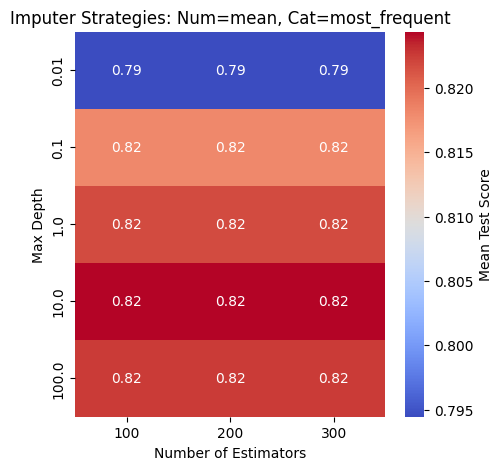

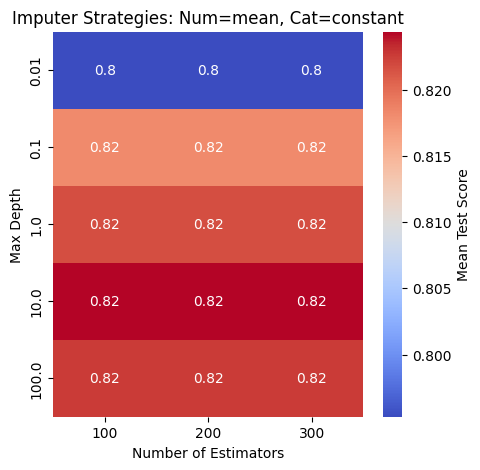

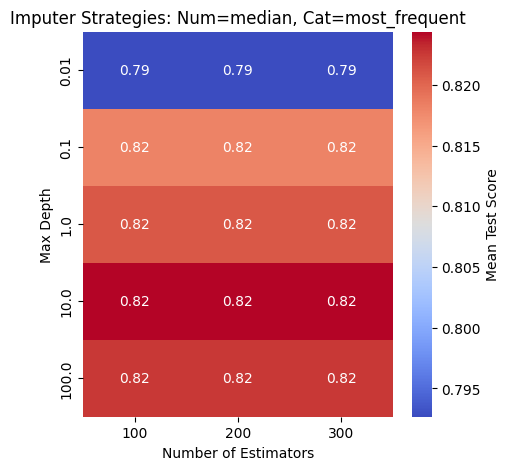

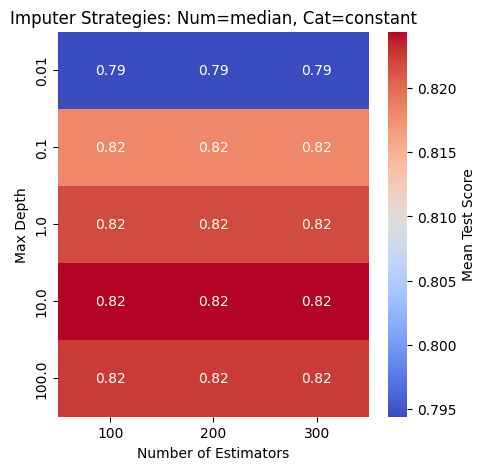

In [30]:
# LogisticRegression grid parameters
logreg_grid_params = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solver algorithms
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}
logreg_model_params = {"random_state": 42, "max_iter": 200}  # Set max_iter for convergence

logistic_regression_clf = train_grids(
    LogisticRegression,
    model_params=logreg_model_params,
    grid_params=logreg_grid_params,
    X_train=X_train_imp,
    X_test=X_test_imp,
    y_train=y_train_imp,
    y_test=y_test_imp,
    heatmap_keys=['C', 'max_iter'],
)

In [31]:
# Create a VotingClassifier with hard or soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('rf', random_forest_clf),
        ('gb', gradient_boosting_clf),
        ('lr', logistic_regression_clf)
    ],
    voting='soft',  # 'soft' for average probability voting, 'hard' for majority voting
    weights=[4, 3, 3],
)

In [32]:
# Fit the ensemble model on the training data
voting_clf.fit(X_train_imp, y_train_imp)

# Evaluate the ensemble model on the test data
y_pred = voting_clf.predict(X_test_imp)
ensemble_test_score = accuracy_score(y_test_imp, y_pred)
print("Ensemble Test Accuracy:", ensemble_test_score)

Ensemble Test Accuracy: 0.8321678321678322


In [33]:
# Transform X_train and X_test using the fitted pipeline
X_train_processed = random_forest_clf.named_steps['preprocessor'].transform(X_train)
X_test_processed = random_forest_clf.named_steps['preprocessor'].transform(X_test)

In [34]:
X_train_processed.shape, X_test_processed.shape

((712, 13), (179, 13))

In [35]:
# Convert transformed data to DataFrames for easier manipulation
X_train_processed_df = pd.DataFrame(
    X_train_processed,
    columns=random_forest_clf.named_steps['preprocessor'].get_feature_names_out(),
)
X_train_processed_df.head()

,num__age,num__sibsp,num__parch,num__fare,cat__pclass_2,cat__pclass_3,cat__sex_male,cat__embarked_Q,cat__embarked_S,cat__who_man,cat__who_woman,cat__adult_male_True,cat__alone_True
0,1.275229,-0.483564,-0.477058,-0.083720,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1,-0.462996,-0.483564,-0.477058,-0.385013,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
2,0.232294,-0.483564,-0.477058,-0.483662,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,-0.231233,0.318617,-0.477058,-0.485039,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,-1.776322,2.725158,1.979468,-0.029778,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
X_test_processed_df = pd.DataFrame(
    X_test_processed,
    columns=random_forest_clf.named_steps['preprocessor'].get_feature_names_out(),
)
X_test_processed_df.head()

,num__age,num__sibsp,num__parch,num__fare,cat__pclass_2,cat__pclass_3,cat__sex_male,cat__embarked_Q,cat__embarked_S,cat__who_man,cat__who_woman,cat__adult_male_True,cat__alone_True
0,5.489260e-16,0.318617,0.751205,-0.341358,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.550396e-01,-0.483564,-0.477058,-0.433609,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
2,-6.947595e-01,-0.483564,-0.477058,-0.483662,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,-1.776322e+00,-0.483564,0.751205,0.003753,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.158286e+00,0.318617,-0.477058,-0.419191,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_train_processed_df.describe()

,num__age,num__sibsp,num__parch,num__fare,cat__pclass_2,cat__pclass_3,cat__sex_male,cat__embarked_Q,cat__embarked_S,cat__who_man,cat__who_woman,cat__adult_male_True,cat__alone_True
count,7.120000e+02,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,3.138673e-02,-0.039661,-0.011284,-0.004289,0.212079,0.558989,0.655899,0.084270,0.740169,0.606742,0.296348,0.606742,0.602528
std,1.003988e+00,0.943689,0.972378,1.010199,0.409068,0.496857,0.475408,0.277987,0.438850,0.488817,0.456967,0.488817,0.489719
min,-2.207402e+00,-0.483564,-0.477058,-0.637711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.402505e-01,-0.483564,-0.477058,-0.483662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.489260e-16,-0.483564,-0.477058,-0.356746,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,4.640575e-01,0.318617,-0.477058,-0.044843,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,3.940508e+00,5.933881,6.892519,9.321091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
# 1. Family size as a new feature
X_train_processed_df['family_size'] = X_train_processed_df['num__sibsp'] + X_train_processed_df['num__parch']
X_test_processed_df['family_size'] = X_test_processed_df['num__sibsp'] + X_test_processed_df['num__parch']

# 2. Fare per person (fare divided by family size + 1 to avoid division by zero)
X_train_processed_df['fare_per_person'] = X_train_processed_df['num__fare'] / (X_train_processed_df['family_size'] + 1)
X_test_processed_df['fare_per_person'] = X_test_processed_df['num__fare'] / (X_test_processed_df['family_size'] + 1)

# 3. Age group - Binning age into categories
age_bins = [0, 12, 18, 30, 50, 80]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
X_train_processed_df['age_group'] = pd.cut(X_train_processed_df['num__age'], bins=age_bins, labels=age_labels)
X_test_processed_df['age_group'] = pd.cut(X_test_processed_df['num__age'], bins=age_bins, labels=age_labels)

# Apply one-hot encoding to age group
X_train_processed_df = pd.get_dummies(X_train_processed_df, columns=['age_group'], drop_first=True)
X_test_processed_df = pd.get_dummies(X_test_processed_df, columns=['age_group'], drop_first=True)

In [39]:
# Access feature importances from the RandomForestClassifier
importances = random_forest_clf.named_steps['classifier'].feature_importances_

# Ensure we get the correct feature names from the preprocessor
feature_names = random_forest_clf.named_steps['preprocessor'].get_feature_names_out()

# Check that the lengths match
if len(importances) != len(feature_names):
    print(f"Length mismatch: {len(importances)} importances vs {len(feature_names)} features")

# Create a DataFrame with feature names and their importances
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display top features
print("Top features based on importance:")
print(feature_importances.head(10))

# Keep only the top N features (e.g., top 10 features)
top_features = feature_importances.head(10)['feature'].values
X_train_top = X_train_processed_df[top_features]
X_test_top = X_test_processed_df[top_features]

Top features based on importance:
                 feature  importance
6          cat__sex_male    0.178492
11  cat__adult_male_True    0.145218
9           cat__who_man    0.128852
3              num__fare    0.111136
5          cat__pclass_3    0.099589
0               num__age    0.091805
10        cat__who_woman    0.084865
1             num__sibsp    0.063908
2             num__parch    0.034731
4          cat__pclass_2    0.028767


In [40]:
X_train_top.shape, y_train.shape

((712, 10), (712,))

In [41]:
# Initialize LGBMClassifier with some basic parameters; you can tune these later
lgbm_clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1, verbose=-1)

# Train the model on the selected top features
lgbm_clf.fit(X_train_top, y_train)

# Make predictions on the test set
y_pred = lgbm_clf.predict(X_test_top)
y_pred_proba = lgbm_clf.predict_proba(X_test_top)[:, 1]  # For AUC score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("LGBMClassifier Accuracy:", accuracy)
print("LGBMClassifier F1 Score:", f1)
print("LGBMClassifier AUC Score:", roc_auc)

LGBMClassifier Accuracy: 0.8268156424581006
LGBMClassifier F1 Score: 0.7832167832167832
LGBMClassifier AUC Score: 0.8785070785070785


In [42]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

In [43]:
# Define the scoring dictionary with multiple metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')  # Updated for compatibility
}

In [44]:
# Initialize the GridSearchCV with the scoring parameter as a dictionary
grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,  # Multiple metrics
    refit='accuracy',  # Select the best model based on accuracy
    cv=5,
    n_jobs=-1,
)

In [45]:
# Fit the model on the training data
grid_search.fit(X_train_top, y_train)

# Display the best parameters and score for each metric
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best F1 Score:", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
print("Best AUC Score:", grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Best Accuracy Score: 0.841307987786861
Best F1 Score: 0.772488136488085
Best AUC Score: 0.8555688055025558


In [46]:
import joblib

# Extract the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_model, 'best_model_pipeline.pkl')
print("Best model saved as 'best_model_pipeline.pkl'")

Best model saved as 'best_model_pipeline.pkl'


In [47]:
# Load the saved best model
loaded_model = joblib.load('best_model_pipeline.pkl')

# Use the loaded model to make predictions on new data
# Assuming `X_new` is the new data to predict on
y_pred = loaded_model.predict(X_test_top)  # Replace `X_test_top` with new data if available

# If you need probabilities for AUC or other metrics:
y_pred_proba = loaded_model.predict_proba(X_test_top)[:, 1]

In [48]:
y_pred_proba

array([0.05822415, 0.22527992, 0.20841268, 0.98505393, 0.43238943,
       0.95755042, 0.73500361, 0.05987134, 0.60518285, 0.98023944,
       0.54493946, 0.10072085, 0.11021779, 0.14754332, 0.1764997 ,
       0.98211412, 0.45024435, 0.69912163, 0.27199373, 0.10960894,
       0.03488906, 0.53777023, 0.4067855 , 0.11745068, 0.09042591,
       0.01642603, 0.43921193, 0.26813825, 0.13669765, 0.68935353,
       0.06500614, 0.65673948, 0.52959203, 0.66910718, 0.097491  ,
       0.2272184 , 0.24845963, 0.73500361, 0.98361545, 0.05760699,
       0.13700977, 0.08565589, 0.08732093, 0.09931245, 0.4271049 ,
       0.17057949, 0.13015275, 0.04286496, 0.182239  , 0.36427576,
       0.89463187, 0.97036525, 0.15118782, 0.95281559, 0.04487067,
       0.97389016, 0.22042766, 0.90765632, 0.96044178, 0.48004841,
       0.11930783, 0.95467126, 0.96814093, 0.13572856, 0.09931245,
       0.93793613, 0.11301768, 0.29586798, 0.1601614 , 0.96598964,
       0.9155073 , 0.89117449, 0.76962142, 0.98153541, 0.05206

In [49]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("LGBMClassifier Accuracy:", accuracy)
print("LGBMClassifier F1 Score:", f1)
print("LGBMClassifier AUC Score:", roc_auc)

LGBMClassifier Accuracy: 0.8156424581005587
LGBMClassifier F1 Score: 0.7659574468085106
LGBMClassifier AUC Score: 0.8842985842985843
